In [1]:
import json, os, re, shutil, sys, time, csv
import collections, itertools

# NLTK for NLP utils and corpora
import nltk
assert(nltk.download('gutenberg'))

# NumPy and TensorFlow
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1."))

# utils.pretty_print_matrix uses Pandas. Configure float format here.
import pandas as pd
pd.set_option('float_format', lambda f: "{0:.04f}".format(f))

# Helper libraries
from shared_lib import utils, vocabulary, rnnlm


[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/sharmila_velamur/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [2]:
canonicalized_words = []
indir = '../preprocess/subset/'
books = []
for root, dirs, filenames in os.walk(indir):
    for filename in filenames:
        if filename.startswith('canonicalized_words_'):
            with open(indir+filename, 'r') as f:
                for line in f.readlines():
                    w = line.rstrip()
                    if w != '':
                        canonicalized_words.append(w)
num_words = len(canonicalized_words)
print num_words
print canonicalized_words[0:10]
print canonicalized_words[num_words-10:num_words]

61772067
['love', "'s", 'meinie', '.', 'three', 'lectures', 'on', 'greek', 'and', 'english']
['wings', 'speeded', 'like', 'thought', 'upon', 'the', 'light', 'of', 'heaven', '.']


In [3]:
from collections import Counter
import operator

tokens_dict = Counter()
for w in canonicalized_words:
    if w.startswith('DG') and w.endswith('DG'):
        w = 'DG'
    tokens_dict[w] += 1
print "Total Tokens: ", len(canonicalized_words)
print "Total Types: ", len(tokens_dict)

Total Tokens:  61772067
Total Types:  244260


In [13]:
t = ''
tokens_list = sorted(tokens_dict)[840:1200]
for i, w in enumerate(tokens_list):
    t += w + '\t'
    if i % 20 is 0:
        print t
        t = ''
    

a'body	
a'chun	a'hm	a'mici	a'morley	a'most	a'onoexibeo	a'ter	a+b	a-a-a	a-a-a-a-a-h	a-a-a-a-h	a-a-a-a-men	a-a-a-arm	a-a-ah	a-a-bc	a-a-h	a-a-i	a-a-men	a-all	a-ask	
a-askin	a-asking	a-b	a-b-abs	a-b-c	a-b-c-d	a-back	a-bang	a-bangin	a-barking	a-batted	a-baying	a-beam	a-beaming	a-bear	a-bearin	a-beating	a-become	a-bed	a-beefin	
a-beeing	a-been	a-beggin	a-begging	a-beggun	a-believed	a-bellow	a-ben	a-bendin	a-berrying	a-bilin	a-biling	a-bin	a-birding	a-birds-nesting	a-black-berrying	a-blackberrying	a-blackin	a-blazin	a-blazing	
a-ble	a-bleachin	a-bleeding	a-blink	a-bloom	a-blowing	a-blubbering	a-blueberrying	a-blushing	a-boilin	a-boiling	a-boomin	a-booming	a-borrying	a-botherin	a-bothering	a-bout	a-brac	a-bragging	a-branching	
a-breath	a-brewdin	a-brewin	a-brewing	a-bringin	a-bristle	a-brooding	a-building	a-burnin	a-burning	a-burying	a-bussin	a-bust	a-busted	a-busting	a-buttin	a-buyin	a-buzz	a-by	a-c	
a-c-b	a-c-d	a-calking	a-callin	a-calling	a-campin	a-capering	a-carried	a-carryin	a-casting	a-

### Plotting the tokens and digging a bit deeper shows the first 2500 tokens are just adding a lot of noise to the data. We will start from 2503th token and proceed from there.

In [14]:
noisy_tokens = sorted(tokens_dict)[0:840]
tokens_list = sorted(tokens_dict)[840:]
print noisy_tokens[0:10]
print tokens_list[0:10]

['!', '!!', '!!!', '!!!!', '!!!!!', '"', '#', '##', '###', '#####']
["a'body", "a'chun", "a'hm", "a'mici", "a'morley", "a'most", "a'onoexibeo", "a'ter", 'a+b', 'a-a-a']


In [30]:
# Let's keep tokens_dict intact so we can look into the original set of tokens 
x = tokens_dict.copy()
for noisy_token in noisy_tokens:
    if x.has_key(noisy_token):
        del x[noisy_token]
tokens = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

In [31]:
print 'Total unique tokens remaining after clean-up: ', len(tokens)
for word, count in tokens[0:10]:
    print word, ': ', count

Total unique tokens remaining after clean-up:  424584
the :  8023153
and :  4574772
of :  4374737
to :  3710837
a :  2948180
in :  2359086
i :  2047810
that :  1887948
he :  1783154
was :  1665368


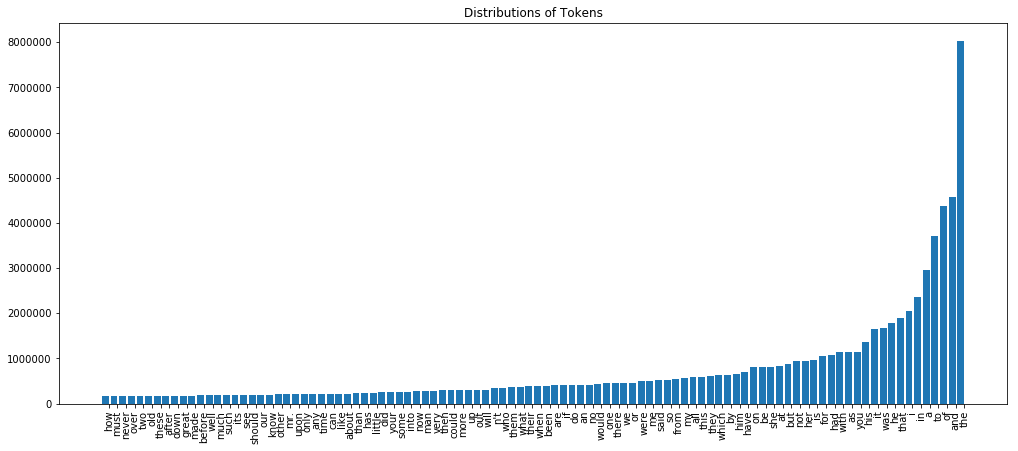

In [108]:
# the histogram of the data
%matplotlib inline
import matplotlib.mlab as mlab
import pylab as pl
import matplotlib.pyplot as plt

results = tokens[0:100]
    
items = (np.array(results)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)

pl.title("Distributions of Tokens")
pl.show()


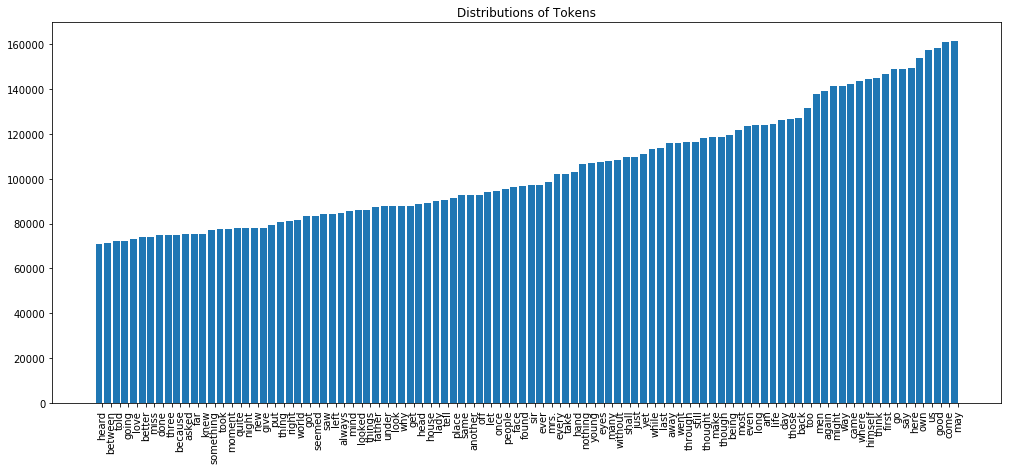

In [109]:
# the histogram of the data
%matplotlib inline
import matplotlib.mlab as mlab
import pylab as pl
import matplotlib.pyplot as plt

results = tokens[100:200]
    
items = (np.array(results)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)

pl.title("Distributions of Tokens")
pl.show()

In [15]:
noisy_tokens = set(noisy_tokens)
words = [ w for w  in canonicalized_words if w not in noisy_tokens ]

In [16]:
print 'Number of tokens after removal of noisy tokens: ', len(words)
## Generate the vocabulary
V = 10000
vocab = vocabulary.Vocabulary((word for word in words), size=V)
vocab.size

Number of tokens after removal of noisy tokens:  50695366


10000

In [7]:
print vocab.wordset.issuperset('the')
print vocab.wordset.issuperset('fawn')
print vocab.wordset.issuperset('!')

True
True
False


In [17]:
sents = []
indir = '../preprocess/subset/'
books = []
for root, dirs, filenames in os.walk(indir):
    for filename in filenames:
        if filename.startswith('parsed_sents_'):
            with open(indir+filename, 'r') as f:
                for line in f.readlines():
                    sents.append(line.rstrip())
num_sents = len(sents)
print num_sents
print sents[num_sents-10:num_sents]

2947370
['<s> For it has occurred to me that it is a good thing to have a Royal Treasurer who is made of money . </s>', '<s> What do you think ? " </s>', '<s> " I think , " said the little Queen , smiling , " that your friend must be the richest man in all the world . " </s>', '<s> " I am , " returned the Scarecrow . </s>', '<s> " but not on account of my money . </s>', '<s> For I consider brains far superior to money , in every way . </s>', '<s> You may have noticed that if one has money without brains , he can not use it to advantage ; but if one has brains without money , they will enable him to live comfortably to the end of his days . " </s>', '<s> " At the same time , " declared the Tin Woodman , " you must acknowledge that a good heart is a thing that brains can not create , and that money can not buy . </s>', '<s> Perhaps , after all , it is I who am the richest man in all the world . " </s>', '<s> 286 " You are both rich , my friends , " said Ozma , gently ; " and your riches 

In [18]:
split=0.8 
shuffle=True

"""Get train and test sentences.

Args:
  corpus: sentences parsed from the Gutenberg Contemporary Authors corpus
  split (double): fraction to use as training set
  shuffle (int or bool): seed for shuffle of input data, or False to just
  take the training data as the first xx% contiguously.
  train_sentences, test_sentences ( list(list(string)) ): the train and test splits
"""

sentences = np.array(sents, dtype=object)
fmt = (len(sentences), sum(map(len, sentences)))
print "Loaded %d sentences (%g tokens)" % fmt

if shuffle:
    rng = np.random.RandomState(shuffle)
    rng.shuffle(sentences)  # in-place
train_frac = 0.8
split_idx = int(train_frac * len(sentences))
train_sentences = sentences[:split_idx]
test_sentences = sentences[split_idx:]

fmt = (len(train_sentences), sum(map(len, train_sentences)))
print "Training set: %d sentences (%d tokens)" % fmt
fmt = (len(test_sentences), sum(map(len, test_sentences)))
print "Test set: %d sentences (%d tokens)" % fmt


Loaded 2947370 sentences (3.53837e+08 tokens)
Training set: 2357896 sentences (283108610 tokens)
Test set: 589474 sentences (70728658 tokens)


In [19]:
def preprocess_sentences(sentences, vocab):
    """Preprocess sentences by canonicalizing and mapping to ids.

    Args:
      sentences ( list(list(string)) ): input sentences
      vocab: Vocabulary object, already initialized

    Returns:
      ids ( array(int) ): flattened array of sentences, including boundary <s>
      tokens.
    """
    # Add sentence boundaries, canonicalize, and handle unknowns
    s_preprocess = []
    for sentence in sentences:
        s = [ utils.canonicalize_word(word, wordset=vocab.word_to_id) for word in sentence.split(" ")]
        s_preprocess.append(vocab.words_to_ids(s))

    return np.array(s_preprocess) 

# ids = preprocess_sentences(corpus[193040:193045], vocab)
# ids

In [20]:
## Preprocess sentences
## convert words to ids based on the vocab wordset created above
## Do this in batches to avoid crashes
batch_size = 50000
num_of_batches = int(round(len(train_sentences) / batch_size))
print 'Preprocessing train sentences - number of batches: ', num_of_batches
train_id_batches = []
start = 0
end = start + batch_size
for i in range(num_of_batches): 
    print 'Batch: ', i
    train_id_batches.append(preprocess_sentences(train_sentences[start:end], vocab))
    start = end
    end += batch_size


Preprocessing train sentences - number of batches:  47
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4
Batch:  5
Batch:  6
Batch:  7
Batch:  8
Batch:  9
Batch:  10
Batch:  11
Batch:  12
Batch:  13
Batch:  14
Batch:  15
Batch:  16
Batch:  17
Batch:  18
Batch:  19
Batch:  20
Batch:  21
Batch:  22
Batch:  23
Batch:  24
Batch:  25
Batch:  26
Batch:  27
Batch:  28
Batch:  29
Batch:  30
Batch:  31
Batch:  32
Batch:  33
Batch:  34
Batch:  35
Batch:  36
Batch:  37
Batch:  38
Batch:  39
Batch:  40
Batch:  41
Batch:  42
Batch:  43
Batch:  44
Batch:  45
Batch:  46


In [21]:
# flatten the lists for 1D tensor
temp = utils.flatten(train_id_batches)
train_ids = utils.flatten(temp)
train_ids = np.array(train_ids)
train_ids[0:10]

array([   0,    3,  811,    5,    2, 2224,   66,    2,    1,    0])

In [22]:
batch_size = 50000
num_of_batches = int(round(len(test_sentences) / batch_size))
if num_of_batches > 10:
    num_of_batches = 10
print 'Preprocessing test sentences - number of batches: ', num_of_batches
test_id_batches = []
start = 0
end = start + batch_size
for i in range(num_of_batches): 
    print 'Batch: ', i
    test_id_batches.append(preprocess_sentences(test_sentences[start:end], vocab))
    start = end
    end += batch_size

Preprocessing test sentences - number of batches:  10
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4
Batch:  5
Batch:  6
Batch:  7
Batch:  8
Batch:  9


In [23]:
# flatten the lists for 1D tensor
test_ids = utils.flatten(utils.flatten(test_id_batches))
test_ids = np.array(test_ids)
test_ids[0:10]

array([  0,   2, 236,   2,  46,   2, 176,   2,   2,   1])

In [33]:
def run_epoch(lm, session, batch_iterator,
              train=False, verbose=False,
              tick_s=10, learning_rate=0.01):
    start_time = time.time()
    tick_time = start_time  # for showing status
    total_cost = 0.0  # total cost, summed over all words
    total_batches = 0
    total_words = 0

    if train:
        train_op = lm.train_step_
        use_dropout = True
        loss = lm.train_loss_
    else:
        train_op = tf.no_op()
        use_dropout = False  # no dropout at test time
        loss = lm.loss_  # true loss, if train_loss is an approximation

    for i, (w, y) in enumerate(batch_iterator):
        cost = 0.0
        
        # At first batch in epoch, get a clean intitial state.
        if i == 0:
            h = session.run(lm.initial_h_, {lm.input_w_: w})

        #### YOUR CODE HERE ####
        feed_dict = {lm.input_w_:w,
                     lm.target_y_:y,
                     lm.initial_h_:h,
                     lm.dropout_keep_prob_: 1.0}
        
        if train:
            cost, train_op_ = session.run([lm.train_loss_, lm.train_step_], feed_dict)
        else:
            cost, train_op_ = session.run([lm.loss_, lm.train_step_], feed_dict)
        ## print "Calling computational graph"
        #cost, train_op_ = session.run([loss, train_op], feed_dict)
        #### END(YOUR CODE) ####
        total_cost += cost
        total_batches = i + 1
        total_words += w.size  # w.size = batch_size * max_time
        
        ##
        # Print average loss-so-far for epoch
        # If using train_loss_, this may be an underestimate.
        if verbose and (time.time() - tick_time >= tick_s):
            avg_cost = total_cost / total_batches
            avg_wps = total_words / (time.time() - start_time)
            print "[batch %d]: seen %d words at %d wps, loss = %.3f" % (
                i, total_words, avg_wps, avg_cost)
            tick_time = time.time()  # reset time ticker
            
        if total_cost <= 0.00001:
            break

    return total_cost / total_batches

In [34]:
def score_dataset(lm, session, ids, name="Data"):
    # For scoring, we can use larger batches to speed things up.
    bi = utils.batch_generator(ids, batch_size=100, max_time=100)
    cost = run_epoch(lm, session, bi, 
                     learning_rate=1.0, train=False, 
                     verbose=False, tick_s=3600)
    print "%s: avg. loss: %.03f  (perplexity: %.02f)" % (name, cost, np.exp(cost))

In [35]:
max_time = 40
batch_size = 64
learning_rate = 0.1 #0.01
num_epochs = 3

# Model parameters
model_params = dict(V=vocab.size, 
                    H=100, 
                    softmax_ns=200,
                    num_layers=1)

TF_SAVEDIR = "tf_saved"
checkpoint_filename = os.path.join(TF_SAVEDIR, "rnnlm")
trained_filename = os.path.join(TF_SAVEDIR, "rnnlm_trained")

In [37]:
reload(utils)
# Will print status every this many seconds
print_interval = 5

# Clear old log directory
shutil.rmtree("tf_summaries", ignore_errors=True)

lm = rnnlm.RNNLM(**model_params)
lm.BuildCoreGraph()
lm.BuildTrainGraph()

# Explicitly add global initializer and variable saver to LM graph
with lm.graph.as_default():
    initializer = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
# Clear old log directory
shutil.rmtree(TF_SAVEDIR, ignore_errors=True)
if not os.path.isdir(TF_SAVEDIR):
    os.makedirs(TF_SAVEDIR)


In [ ]:
with tf.Session(graph=lm.graph) as session:
    # Seed RNG for repeatability
    tf.set_random_seed(42)
    session.run(initializer)
    bi = utils.batch_generator(train_ids, batch_size, max_time)
    for epoch in xrange(1,num_epochs+1):
        t0_epoch = time.time()
        bi = utils.batch_generator(train_ids, batch_size, max_time)
        print "[epoch %d] Starting epoch %d" % (epoch, epoch)
        #### YOUR CODE HERE ####
        # Run a training epoch.
        
        run_epoch(lm, session, bi, train=True, verbose=False,
              tick_s=10,learning_rate=learning_rate)
        
        #### END(YOUR CODE) ####
        print "[epoch %d] Completed in %s" % (epoch, utils.pretty_timedelta(since=t0_epoch))
    
        # Save a checkpoint
        saver.save(session, checkpoint_filename, global_step=epoch)
        ##
        # score_dataset will run a forward pass over the entire dataset
        # and report perplexity scores. This can be slow (around 1/2 to 
        # 1/4 as long as a full epoch), so you may want to comment it out
        # to speed up training on a slow machine. Be sure to run it at the 
        # end to evaluate your score.
        print ("[epoch %d]" % epoch),
        score_dataset(lm, session, train_ids, name="Train set")
        print ("[epoch %d]" % epoch),
        score_dataset(lm, session, test_ids, name="Test set")
        print ""
    # Save final model
    saver.save(session, trained_filename)

[epoch 1] Starting epoch 1


In [ ]:
def score_seq(lm, session, seq, vocab):
    """Score a sequence of words. Returns total log-probability."""
    padded_ids = vocab.words_to_ids(utils.canonicalize_words(["<s>"] + seq + ["</s>"], 
                                                             wordset=vocab.word_to_id))
    w = np.reshape(padded_ids[:-1], [1,-1])
    y = np.reshape(padded_ids[1:],  [1,-1])
    h = session.run(lm.initial_h_, {lm.input_w_: w})
    feed_dict = {lm.input_w_:w,
                 lm.target_y_:y,
                 lm.initial_h_:h,
                 lm.dropout_keep_prob_: 1.0}
    # Return log(P(seq)) = -1*loss
    return -1*session.run(lm.loss_, feed_dict)

def load_and_score(inputs, sort=False):
    """Load the trained model and score the given words."""
    lm = rnnlm.RNNLM(**model_params)
    lm.BuildCoreGraph()
    
    with lm.graph.as_default():
        saver = tf.train.Saver()

    with tf.Session(graph=lm.graph) as session:  
        # Load the trained model
        saver.restore(session, trained_filename)

        if isinstance(inputs[0], str) or isinstance(inputs[0], unicode):
            inputs = [inputs]

        # Actually run scoring
        results = []
        for words in inputs:
            score = score_seq(lm, session, words, vocab)
            results.append((score, words))

        # Sort if requested
        if sort: results = sorted(results, reverse=True)

        # Print results
        for score, words in results:
            print "\"%s\" : %.02f" % (" ".join(words), score)

In [ ]:
sents = ["i shall be miserable if i have not an excellent library",
         "to be fond of dancing was a certain step towards falling in love",
         "don't let the door hit you on your way out",
         "he was totally into it",
         "to be or not to be",
         "come on y'all, don't be like that!",
         "get outta here",
        "the market dropped significantly today",
        "i do not fear computers, i fear the lack of them"]
load_and_score([s.split() for s in sents])

In [ ]:
def sample_step(lm, session, input_w, initial_h):
    """Run a single RNN step and return sampled predictions.
  
    Args:
      lm : rnnlm.RNNLM
      session: tf.Session
      input_w : [batch_size] vector of indices
      initial_h : [batch_size, hidden_dims] initial state
    
    Returns:
      final_h : final hidden state, compatible with initial_h
      samples : [batch_size, 1] vector of indices
    """
    # Reshape input to column vector
    input_w = np.array(input_w, dtype=np.int32).reshape([-1,1])
  
    #### YOUR CODE HERE ####
    # Run sample ops
    final_h, samples = session.run([lm.final_h_, lm.pred_samples_], 
        feed_dict={lm.input_w_: input_w, lm.initial_h_: initial_h, lm.dropout_keep_prob_:1.0, lm.learning_rate_:0.1})


    #### END(YOUR CODE) ####
    # Note indexing here: 
    #   [batch_size, max_time, 1] -> [batch_size, 1]
    return final_h, samples[:,-1,:]



